In [1]:
#Import libraries
import torch
import glob
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision.models import resnet18
from torchvision import transforms, models
from sklearn.model_selection import StratifiedShuffleSplit
from google.colab import drive

drive.mount('/content/drive')

# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

Mounted at /content/drive
cuda:0


In [77]:
class BaseDataset(Dataset):
    def __init__(self,data_dic, transform = None):
        self.file_paths = data_dic["X"]
        self.labels = data_dic["Y"]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)


    def __getitem__(self,idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]

        #Read an image with PIL
        image = Image.open(file_path)

        if self.transform:
            image = self.transform(image)
        return image, label

In [78]:
images = glob.glob('/content/drive/MyDrive/all_photos/*/*.jpg')
images = np.array(images)
labels = np.asarray([f.split("/")[-2] for f in images])
print(len(images))
print(labels.size)
print(images[0])
print(labels[0])

126
126
/content/drive/MyDrive/all_photos/blue/graph_paper.jpg
blue


In [79]:
classes = np.unique(labels).flatten()
print(classes)
labels_int = np.zeros(labels.size, dtype = np.int64)
print(labels_int.shape)
for ii,jj in enumerate(classes):
    labels_int[labels == jj] = ii

['black' 'blue' 'green' 'other']
(126,)


In [80]:
for ii in range(4):
    print("Label ", ii, ":", (labels_int == ii).sum())

Label  0 : 32
Label  1 : 31
Label  2 : 32
Label  3 : 31


In [81]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size= 0.2, random_state=10)
sss.get_n_splits(images,labels_int)
dev_index, test_index = next(sss.split(images,labels_int))

dev_images = images[dev_index]
dev_labels = labels_int[dev_index]

test_images = images[test_index]
test_labels = labels_int[test_index]

In [82]:
sss2 = StratifiedShuffleSplit(n_splits = 1, test_size= 0.2, random_state=10)
sss2.get_n_splits(dev_images,dev_labels)
train_index, val_index = next(sss2.split(dev_images,dev_labels))

train_images = images[train_index]
train_labels = labels_int[train_index]

val_images = images[val_index]
val_labels = labels_int[val_index]

In [83]:
print("Train set:", train_images.size)
print("Val set:", val_images.size)
print("Test set:", test_images.size)

Train set: 80
Val set: 20
Test set: 26


In [84]:
train_set = {"X": train_images, "Y": train_labels}
val_set = {"X": val_images, "Y": val_labels}
test_set = {"X": test_images, "Y": test_labels}

In [85]:
torchvision_transform = transforms.Compose([transforms.Resize((224,224)),\
    transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
    transforms.ToTensor(),transforms.Normalize(mean = [0.4120, 0.3768, 0.3407],std = [0.2944,0.2759,0.2598])])


torchvision_transform_test = transforms.Compose([transforms.Resize((224,224)),\
    transforms.ToTensor(),transforms.Normalize(mean = [0.4120, 0.3768, 0.3407],std = [0.2944,0.2759,0.2598])])

In [86]:
train_dataset = BaseDataset(train_set, transform=torchvision_transform)
val_dataset = BaseDataset(val_set, transform=torchvision_transform)
test_dataset = BaseDataset(test_set, transform=torchvision_transform_test)

In [87]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size= 16, shuffle = True, num_workers= 0)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size= 16, num_workers= 0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size= 16, num_workers= 0)

In [88]:
def get_dataset_stats(data_loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader:
        data = data[0]  # Get the images to compute the stgatistics
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

In [89]:
print(get_dataset_stats(trainloader))

(tensor([0.4163, 0.4840, 0.5194]), tensor([0.5713, 0.6117, 0.6468]))


In [90]:
train_iterator = iter(trainloader)
train_batch = next(train_iterator)

In [91]:
print(train_batch[0].size())
print(train_batch[1].size())

torch.Size([16, 3, 224, 224])
torch.Size([16])


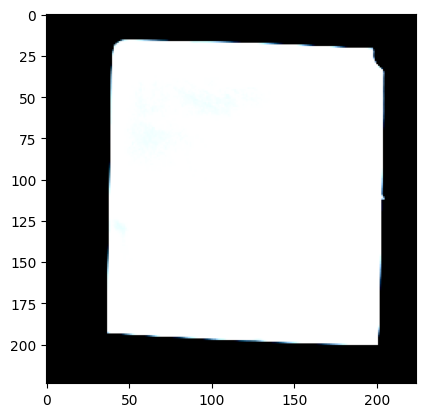

In [92]:
plt.figure()
plt.imshow(train_batch[0].numpy()[15].transpose(1,2,0))
plt.show()

In [93]:
class GarbageModel(nn.Module):
    def __init__(self,  num_classes, input_shape, transfer=False):
        super().__init__()

        self.transfer = transfer
        self.num_classes = num_classes
        self.input_shape = input_shape

        # transfer learning if pretrained=True
        self.feature_extractor = models.resnet18(pretrained=transfer)

        if self.transfer:
            # layers are frozen by using eval()
            self.feature_extractor.eval()
            # freeze params
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

        n_features = self._get_conv_output(self.input_shape)
        self.classifier = nn.Linear(n_features, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self.feature_extractor(tmp_input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    # will be used during inference
    def forward(self, x):
       x = self.feature_extractor(x)
       x = x.view(x.size(0), -1)
       x = self.classifier(x)

       return x

In [94]:
net = GarbageModel(4, (3,224,224), False)
net.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


GarbageModel(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [95]:
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.AdamW(net.parameters(), lr = 0.001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [96]:
nepochs = 10
PATH = './garbage_net.pth' # Path to save the best model

best_loss = 1e+20
for epoch in range(nepochs):  # loop over the dataset multiple times
    # Training Loop
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'{epoch + 1},  train loss: {train_loss / i:.3f},', end = ' ')
    scheduler.step()

    val_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            avg_val_loss = val_loss / len(valloader)
        print(f'val loss: {avg_val_loss:.3f}')


        # Save best model
        if avg_val_loss < best_loss:
            print("Saving model")
            torch.save(net.state_dict(), PATH)
            best_loss = val_loss

print('Finished Training')

1,  train loss: 2.859, val loss: 1.561
Saving model
2,  train loss: 2.045, val loss: 1.007
Saving model
3,  train loss: 1.539, val loss: 0.938
Saving model
4,  train loss: 1.615, val loss: 0.880
Saving model
5,  train loss: 1.476, val loss: 0.905
Saving model
6,  train loss: 1.312, val loss: 1.097
Saving model
7,  train loss: 1.258, val loss: 1.220
Saving model
8,  train loss: 1.196, val loss: 1.195
Saving model
9,  train loss: 1.110, val loss: 1.046
Saving model
10,  train loss: 1.098, val loss: 1.076
Saving model
Finished Training


In [97]:
# Load the best model to be used in the test set
net = GarbageModel(4, (3,224,224), False)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [98]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 50.0 %
